# TTC Delay Prediction Toronto

## Project: AI-based Delay Prediction for Toronto Transit (Bus, Subway, Streetcar)

This notebook performs end-to-end **EDA + data processing** on TTC delay data from **raw files** (2017–2025).

**Important:** if you see old outputs referencing a pre-built unified CSV, those are from previous runs. Re-run cells from the top to regenerate outputs from raw files.

### Objectives:
1. **Import and analyze raw data** from each source (Bus, Subway, Streetcar)
2. **Understand column structure** for each dataset separately
3. **Unify/merge datasets** with proper column mapping
4. **Data quality analysis** (missing values, outliers, data types)
5. **Data processing**:
   - Handle missing values
   - Normalization/transformation
   - Feature engineering
   - Address data imbalance
   - Define target variable
6. **Exploratory analysis** of processed data
7. **Save a processed dataset** for future modeling notebooks (no training here)

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime
import json

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Libraries imported successfully!
Pandas version: 3.0.0
NumPy version: 2.4.2
Matplotlib version: 3.10.8
Seaborn version: 0.13.2


## 1. Raw Data Import (per dataset)

We start by loading *raw* TTC delay datasets for **Bus**, **Streetcar**, and **Subway** (2017–2025) and inspecting their schemas separately before any merging.

In [35]:
# Define paths
BASE_DIR = Path.cwd().parent
DATASET_DIR = BASE_DIR / "dataset"

BUS_DIR = DATASET_DIR / "ttc-bus-delay-data"
STREETCAR_DIR = DATASET_DIR / "ttc-streetcar-delay-data"
SUBWAY_DIR = DATASET_DIR / "ttc-subway-delay-data"

print(f"Base directory: {BASE_DIR}")
print(f"Dataset directory: {DATASET_DIR}")
print(f"\nRaw data folders:")
print(f"  BUS:       {BUS_DIR} (exists={BUS_DIR.exists()})")
print(f"  STREETCAR: {STREETCAR_DIR} (exists={STREETCAR_DIR.exists()})")
print(f"  SUBWAY:    {SUBWAY_DIR} (exists={SUBWAY_DIR.exists()})")

Base directory: /Users/feliperosa/Downloads/02_codigos/github/centennialCollege_AICapstoneProject
Dataset directory: /Users/feliperosa/Downloads/02_codigos/github/centennialCollege_AICapstoneProject/dataset

Raw data folders:
  BUS:       /Users/feliperosa/Downloads/02_codigos/github/centennialCollege_AICapstoneProject/dataset/ttc-bus-delay-data (exists=True)
  STREETCAR: /Users/feliperosa/Downloads/02_codigos/github/centennialCollege_AICapstoneProject/dataset/ttc-streetcar-delay-data (exists=True)
  SUBWAY:    /Users/feliperosa/Downloads/02_codigos/github/centennialCollege_AICapstoneProject/dataset/ttc-subway-delay-data (exists=True)


In [36]:
# Load small raw samples to inspect schema (no unified dataset)
print("=" * 70)
print("RAW DATA SAMPLES (schema preview)")
print("=" * 70)

bus_sample_file = BUS_DIR / "ttc-bus-delay-data-2017.xlsx"
streetcar_sample_file = STREETCAR_DIR / "ttc-streetcar-delay-data-2017.xlsx"
subway_sample_file = SUBWAY_DIR / "ttc-subway-delay-data-2018.xlsx"  # subway 2017 is split

bus_csv_2025 = BUS_DIR / "TTCBusDelayDatasince2025.csv"
streetcar_csv_2025 = STREETCAR_DIR / "TTCStreetcarDelayDatasince2025.csv"
subway_csv_2025 = SUBWAY_DIR / "TTCSubwayDelayDatasince2025.csv"

# BUS XLSX sample
if bus_sample_file.exists():
    df_bus_sample = pd.read_excel(bus_sample_file, nrows=10)
    print(f"\nBUS sample (XLSX): {bus_sample_file.name}")
    print(f"Shape: {df_bus_sample.shape}")
    print(f"Columns: {list(df_bus_sample.columns)}")
    df_bus_sample.head()
else:
    print(f"\n⚠ BUS sample file not found: {bus_sample_file}")

# STREETCAR XLSX sample
if streetcar_sample_file.exists():
    df_streetcar_sample = pd.read_excel(streetcar_sample_file, nrows=10)
    print(f"\nSTREETCAR sample (XLSX): {streetcar_sample_file.name}")
    print(f"Shape: {df_streetcar_sample.shape}")
    print(f"Columns: {list(df_streetcar_sample.columns)}")
    df_streetcar_sample.head()
else:
    print(f"\n⚠ STREETCAR sample file not found: {streetcar_sample_file}")

# SUBWAY XLSX sample
if subway_sample_file.exists():
    df_subway_sample = pd.read_excel(subway_sample_file, nrows=10)
    print(f"\nSUBWAY sample (XLSX): {subway_sample_file.name}")
    print(f"Shape: {df_subway_sample.shape}")
    print(f"Columns: {list(df_subway_sample.columns)}")
    df_subway_sample.head()
else:
    print(f"\n⚠ SUBWAY sample file not found: {subway_sample_file}")

# CSV 2025 samples (BUS only preview; others have same schema but different ordering)
if bus_csv_2025.exists():
    df_bus_csv_sample = pd.read_csv(bus_csv_2025, nrows=10)
    print(f"\nBUS sample (CSV, since 2025): {bus_csv_2025.name}")
    print(f"Shape: {df_bus_csv_sample.shape}")
    print(f"Columns: {list(df_bus_csv_sample.columns)}")
    df_bus_csv_sample.head()
else:
    print(f"\n⚠ BUS 2025 CSV not found: {bus_csv_2025}")

RAW DATA SAMPLES (schema preview)

BUS sample (XLSX): ttc-bus-delay-data-2017.xlsx
Shape: (10, 10)
Columns: ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']

STREETCAR sample (XLSX): ttc-streetcar-delay-data-2017.xlsx
Shape: (10, 10)
Columns: ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']

SUBWAY sample (XLSX): ttc-subway-delay-data-2018.xlsx
Shape: (10, 10)
Columns: ['Date', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Line', 'Vehicle']

BUS sample (CSV, since 2025): TTCBusDelayDatasince2025.csv
Shape: (10, 11)
Columns: ['_id', 'Date', 'Line', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle']


## 2. Raw Schema (Columns & Dtypes)

Here we compare **columns** and **dtypes** across raw sources and define the mapping needed for unification.

In [37]:
print("=" * 70)
print("RAW COLUMN STRUCTURE COMPARISON")
print("=" * 70)

samples = []

if 'df_bus_sample' in locals():
    samples.append(("BUS_XLSX", df_bus_sample))
if 'df_streetcar_sample' in locals():
    samples.append(("STREETCAR_XLSX", df_streetcar_sample))
if 'df_subway_sample' in locals():
    samples.append(("SUBWAY_XLSX", df_subway_sample))
if 'df_bus_csv_sample' in locals():
    samples.append(("BUS_CSV_2025", df_bus_csv_sample))

for name, sdf in samples:
    print(f"\n{name}")
    print(f"  Columns ({len(sdf.columns)}): {list(sdf.columns)}")
    print("  Dtypes:")
    for col, dt in sdf.dtypes.items():
        print(f"    {col:20s} -> {dt}")

print("\n" + "=" * 70)
print("UNIFICATION MAPPING")
print("=" * 70)

# Mapping into the standard schema
standard_schema = [
    'Vehicle_Type', 'Date', 'Line', 'Time', 'Day', 'Station',
    'Code', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle'
]
print("Standard schema:")
print("  " + ", ".join(standard_schema))

print("\nBUS/STREETCAR (XLSX) -> standard")
print("  Report Date -> Date")
print("  Route       -> Line")
print("  Location    -> Station")
print("  Incident    -> Code")
print("  Direction   -> Bound")

print("\nSUBWAY (XLSX) -> standard")
print("  Already aligned (Date/Line/Station/Code/Bound exist)")

print("\nCSV since 2025 -> standard")
print("  Drop _id")
print("  Already aligned (Date/Line/Station/Code/Bound exist)")

RAW COLUMN STRUCTURE COMPARISON

BUS_XLSX
  Columns (10): ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']
  Dtypes:
    Report Date          -> datetime64[us]
    Route                -> int64
    Time                 -> object
    Day                  -> str
    Location             -> str
    Incident             -> str
    Min Delay            -> int64
    Min Gap              -> int64
    Direction            -> str
    Vehicle              -> int64

STREETCAR_XLSX
  Columns (10): ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']
  Dtypes:
    Report Date          -> datetime64[us]
    Route                -> int64
    Time                 -> object
    Day                  -> str
    Location             -> str
    Incident             -> str
    Min Delay            -> int64
    Min Gap              -> int64
    Direction            -> str
    Vehicle     

In [38]:
# Quick sanity check: date/time parsing on raw samples
print("=" * 70)
print("RAW PARSING SANITY CHECK")
print("=" * 70)

from pandas import to_datetime

def parse_rate(series, fmt=None):
    parsed = to_datetime(series, errors='coerce', format=fmt)
    return float(parsed.notna().mean())

if 'df_bus_sample' in locals():
    print("\nBUS_XLSX")
    print("  Date parse rate:", parse_rate(df_bus_sample.get('Report Date', pd.Series(dtype='object'))))
    print("  Time parse rate:", parse_rate(df_bus_sample.get('Time', pd.Series(dtype='object')), fmt='%H:%M:%S'))

if 'df_streetcar_sample' in locals():
    print("\nSTREETCAR_XLSX")
    print("  Date parse rate:", parse_rate(df_streetcar_sample.get('Report Date', pd.Series(dtype='object'))))
    print("  Time parse rate:", parse_rate(df_streetcar_sample.get('Time', pd.Series(dtype='object')), fmt='%H:%M:%S'))

if 'df_subway_sample' in locals():
    print("\nSUBWAY_XLSX")
    print("  Date parse rate:", parse_rate(df_subway_sample.get('Date', pd.Series(dtype='object'))))
    print("  Time parse rate:", parse_rate(df_subway_sample.get('Time', pd.Series(dtype='object')), fmt='%H:%M:%S'))

RAW PARSING SANITY CHECK

BUS_XLSX
  Date parse rate: 1.0
  Time parse rate: 1.0

STREETCAR_XLSX
  Date parse rate: 1.0
  Time parse rate: 1.0

SUBWAY_XLSX
  Date parse rate: 1.0
  Time parse rate: 0.0


## 3. Load All Raw Files (2017–2025) + Standardize + Merge

Now we load **all** raw files for each vehicle type, apply the mapping into the standard schema, and merge everything into a single dataframe.

In [39]:
# Function to standardize columns
def standardize_columns(df, vehicle_type):
    """Standardize column names across different file formats"""
    df = df.copy()
    
    # Column mapping for BUS and STREETCAR
    if vehicle_type in ['bus', 'streetcar']:
        column_mapping = {
            'Report Date': 'Date',
            'Route': 'Line',
            'Location': 'Station',
            'Incident': 'Code',
            'Direction': 'Bound'
        }
        df = df.rename(columns=column_mapping)
    
    # Remove _id column if present (from CSV files)
    if '_id' in df.columns:
        df = df.drop(columns=['_id'])
    
    # Add Vehicle_Type column
    df['Vehicle_Type'] = vehicle_type.upper()
    
    # Select and reorder standard columns
    standard_columns = ['Vehicle_Type', 'Date', 'Line', 'Time', 'Day', 'Station', 
                       'Code', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle']
    available_columns = [col for col in standard_columns if col in df.columns]
    df = df[available_columns]
    
    return df

# Load all data files
print("=" * 70)
print("LOADING ALL RAW DATA FILES")
print("=" * 70)

all_dataframes = []
years = list(range(2017, 2025))  # 2017 to 2024

# Load BUS data
print("\n🚌 Loading BUS data...")
for year in years:
    bus_file = BUS_DIR / f"ttc-bus-delay-data-{year}.xlsx"
    if bus_file.exists():
        try:
            df_bus = pd.read_excel(bus_file)
            df_bus = standardize_columns(df_bus, 'bus')
            all_dataframes.append(df_bus)
            print(f"   ✓ {year}: {len(df_bus):,} records")
        except Exception as e:
            print(f"   ✗ {year}: Error - {e}")

# Load STREETCAR data
print("\n🚋 Loading STREETCAR data...")
for year in years:
    streetcar_file = STREETCAR_DIR / f"ttc-streetcar-delay-data-{year}.xlsx"
    if streetcar_file.exists():
        try:
            df_streetcar = pd.read_excel(streetcar_file)
            df_streetcar = standardize_columns(df_streetcar, 'streetcar')
            all_dataframes.append(df_streetcar)
            print(f"   ✓ {year}: {len(df_streetcar):,} records")
        except Exception as e:
            print(f"   ✗ {year}: Error - {e}")

# Load SUBWAY data
print("\n🚇 Loading SUBWAY data...")
# Special handling for 2017 (split files)
subway_2017_files = [
    SUBWAY_DIR / "ttc-subway-delay-jan-2014-april-2017.xlsx",
    SUBWAY_DIR / "ttc-subway-delay-may-december-2017.xlsx"
]
for file in subway_2017_files:
    if file.exists():
        try:
            df_subway = pd.read_excel(file)
            df_subway['Date'] = pd.to_datetime(df_subway['Date'], errors='coerce')
            df_subway = df_subway[df_subway['Date'].dt.year == 2017]
            df_subway = standardize_columns(df_subway, 'subway')
            all_dataframes.append(df_subway)
            print(f"   ✓ 2017 ({file.name}): {len(df_subway):,} records")
        except Exception as e:
            print(f"   ✗ 2017 ({file.name}): Error - {e}")

# Load subway 2018-2024
for year in range(2018, 2025):
    subway_file = SUBWAY_DIR / f"ttc-subway-delay-data-{year}.xlsx"
    if subway_file.exists():
        try:
            df_subway = pd.read_excel(subway_file)
            df_subway = standardize_columns(df_subway, 'subway')
            all_dataframes.append(df_subway)
            print(f"   ✓ {year}: {len(df_subway):,} records")
        except Exception as e:
            print(f"   ✗ {year}: Error - {e}")

# Load CSV 2025 data
print("\n📄 Loading CSV 2025 data...")
for vehicle_type in ['bus', 'streetcar', 'subway']:
    csv_file = DATASET_DIR / f"ttc-{vehicle_type}-delay-data" / f"TTC{vehicle_type.capitalize()}DelayDatasince2025.csv"
    if csv_file.exists():
        try:
            df_csv = pd.read_csv(csv_file)
            df_csv = standardize_columns(df_csv, vehicle_type)
            all_dataframes.append(df_csv)
            print(f"   ✓ {vehicle_type.upper()}: {len(df_csv):,} records")
        except Exception as e:
            print(f"   ✗ {vehicle_type.upper()}: Error - {e}")

print(f"\n✓ Total files loaded: {len(all_dataframes)}")

LOADING ALL RAW DATA FILES

🚌 Loading BUS data...
   ✓ 2017: 5,300 records
   ✓ 2018: 6,969 records
   ✓ 2019: 6,743 records
   ✓ 2020: 4,282 records
   ✓ 2021: 2,832 records
   ✓ 2022: 58,707 records
   ✓ 2023: 56,207 records
   ✓ 2024: 59,643 records

🚋 Loading STREETCAR data...
   ✓ 2017: 1,300 records
   ✓ 2018: 1,622 records
   ✓ 2019: 1,595 records
   ✓ 2020: 802 records
   ✓ 2021: 1,018 records
   ✓ 2022: 17,655 records
   ✓ 2023: 14,413 records
   ✓ 2024: 14,206 records

🚇 Loading SUBWAY data...
   ✓ 2017 (ttc-subway-delay-jan-2014-april-2017.xlsx): 5,956 records
   ✓ 2017 (ttc-subway-delay-may-december-2017.xlsx): 1,634 records
   ✓ 2018: 1,873 records
   ✓ 2019: 1,871 records
   ✓ 2020: 1,339 records
   ✓ 2021: 1,216 records
   ✓ 2022: 19,895 records
   ✓ 2023: 22,949 records
   ✓ 2024: 26,467 records

📄 Loading CSV 2025 data...
   ✓ BUS: 63,029 records
   ✓ STREETCAR: 14,419 records
   ✓ SUBWAY: 25,713 records

✓ Total files loaded: 28


In [40]:
# Combine all dataframes
print("\n" + "=" * 70)
print("COMBINING ALL DATASETS")
print("=" * 70)

if all_dataframes:
    df = pd.concat(all_dataframes, ignore_index=True)
    print(f"\n✓ Combined dataset created!")
    print(f"  Total records: {len(df):,}")
    print(f"  Total columns: {len(df.columns)}")
    print(f"  Columns: {list(df.columns)}")
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    
    # Filter to 2017-2025
    df = df[(df['Date'].dt.year >= 2017) & (df['Date'].dt.year <= 2025)]
    
    print(f"\n✓ After filtering to 2017-2025:")
    print(f"  Total records: {len(df):,}")
    print(f"\n  First few rows:")
    print(df.head())
    
    print(f"\n  Vehicle type distribution:")
    print(df['Vehicle_Type'].value_counts())
else:
    print("\n⚠️  No dataframes to combine!")
    df = pd.DataFrame()


COMBINING ALL DATASETS

✓ Combined dataset created!
  Total records: 439,655
  Total columns: 11
  Columns: ['Vehicle_Type', 'Date', 'Line', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle']

✓ After filtering to 2017-2025:
  Total records: 439,655

  First few rows:
  Vehicle_Type       Date Line      Time     Day                Station  \
0          BUS 2017-01-01   73  00:42:00  Sunday   Claireport at Albion   
1          BUS 2017-01-01   75  01:02:00  Sunday              Glen /Elm   
2          BUS 2017-01-01  102  01:20:00  Sunday         Warden Station   
3          BUS 2017-01-01  120  01:22:00  Sunday  Sheppard at Northover   
4          BUS 2017-01-01   83  01:30:00  Sunday       Donlands station   

                 Code  Min Delay  Min Gap Bound  Vehicle  
0          Mechanical       20.0     20.0     S   8091.0  
1  Emergency Services       30.0     60.0     n   1821.0  
2          Mechanical       10.0     20.0   NaN   8114.0  
3          Mecha

## 4. Data Processing: Handle Missing Values

Analyze and handle missing values in the unified dataset.

MISSING VALUES ANALYSIS (BEFORE PROCESSING)

Columns with missing values (6):
   Column  Missing_Count  Missing_Percentage Data_Type
    Bound          88664           20.166722       str
  Min Gap           5146            1.170463   float64
Min Delay           5118            1.164095   float64
  Vehicle           3177            0.722612   float64
     Line           3097            0.704416    object
  Station             76            0.017286       str


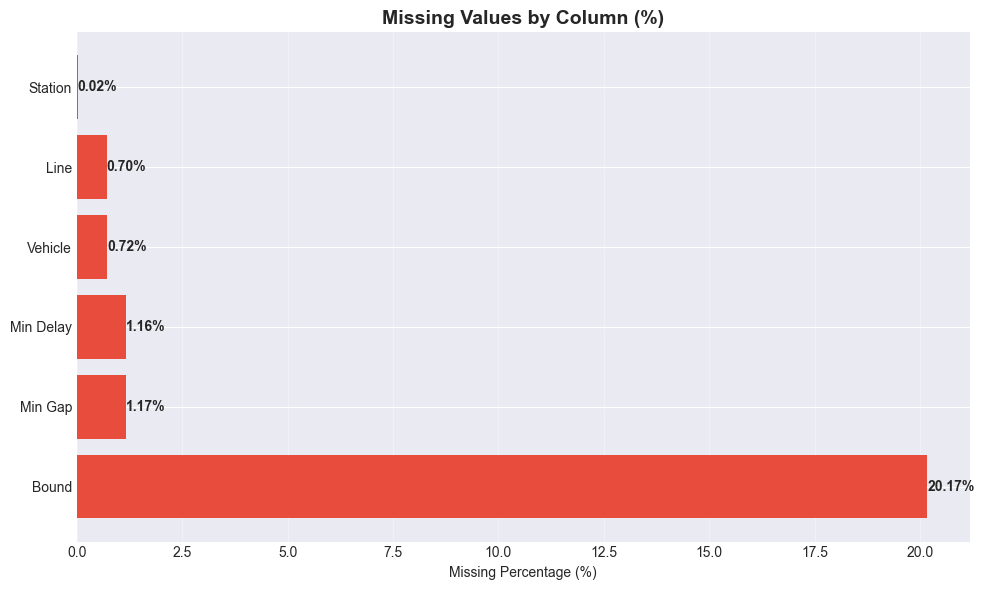


Total missing values: 105,278
Percentage of missing data: 2.18%


In [41]:
# Analyze missing values before processing
print("=" * 70)
print("MISSING VALUES ANALYSIS (BEFORE PROCESSING)")
print("=" * 70)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).values,
    'Data_Type': df.dtypes.values
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print(f"\nColumns with missing values ({len(missing_data)}):")
    print(missing_data.to_string(index=False))
    
    # Visualize missing values
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(missing_data['Column'], missing_data['Missing_Percentage'], color='#e74c3c')
    ax.set_title('Missing Values by Column (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Missing Percentage (%)')
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(missing_data['Missing_Percentage']):
        ax.text(v, i, f'{v:.2f}%', va='center', fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No missing values found!")

print(f"\nTotal missing values: {df.isnull().sum().sum():,}")
print(f"Percentage of missing data: {(df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100):.2f}%")

In [42]:
# Handle missing values
print("\n" + "=" * 70)
print("HANDLING MISSING VALUES")
print("=" * 70)

df_processed = df.copy()
initial_missing = df_processed.isnull().sum().sum()

# Strategy for each column
print("\nMissing value handling strategy:")

# 1. Bound: Fill with 'Unknown' (categorical)
if 'Bound' in df_processed.columns:
    missing_bound = df_processed['Bound'].isnull().sum()
    if missing_bound > 0:
        df_processed['Bound'] = df_processed['Bound'].fillna('Unknown')
        print(f"  ✓ Bound: Filled {missing_bound:,} missing values with 'Unknown'")

# 2. Vehicle: Fill with 0 or mode (numerical)
if 'Vehicle' in df_processed.columns:
    missing_vehicle = df_processed['Vehicle'].isnull().sum()
    if missing_vehicle > 0:
        # Use mode by vehicle type
        for vtype in df_processed['Vehicle_Type'].unique():
            mode_vehicle = df_processed[df_processed['Vehicle_Type'] == vtype]['Vehicle'].mode()
            if len(mode_vehicle) > 0:
                df_processed.loc[(df_processed['Vehicle_Type'] == vtype) & 
                                (df_processed['Vehicle'].isnull()), 'Vehicle'] = mode_vehicle[0]
            else:
                df_processed.loc[(df_processed['Vehicle_Type'] == vtype) & 
                                (df_processed['Vehicle'].isnull()), 'Vehicle'] = 0
        print(f"  ✓ Vehicle: Filled {missing_vehicle:,} missing values with mode/0")

# 3. Line: Fill with 'Unknown' (categorical)
if 'Line' in df_processed.columns:
    missing_line = df_processed['Line'].isnull().sum()
    if missing_line > 0:
        df_processed['Line'] = df_processed['Line'].fillna('Unknown')
        print(f"  ✓ Line: Filled {missing_line:,} missing values with 'Unknown'")

# 4. Station: Fill with 'Unknown' (categorical)
if 'Station' in df_processed.columns:
    missing_station = df_processed['Station'].isnull().sum()
    if missing_station > 0:
        df_processed['Station'] = df_processed['Station'].fillna('Unknown')
        print(f"  ✓ Station: Filled {missing_station:,} missing values with 'Unknown'")

# 5. Min Delay and Min Gap: Fill with median by vehicle type
for col in ['Min Delay', 'Min Gap']:
    if col in df_processed.columns:
        missing = df_processed[col].isnull().sum()
        if missing > 0:
            for vtype in df_processed['Vehicle_Type'].unique():
                median_val = df_processed[df_processed['Vehicle_Type'] == vtype][col].median()
                df_processed.loc[(df_processed['Vehicle_Type'] == vtype) & 
                                (df_processed[col].isnull()), col] = median_val
            print(f"  ✓ {col}: Filled {missing:,} missing values with median by vehicle type")

# 6. Date and Time: Drop rows with missing critical temporal data
if 'Date' in df_processed.columns:
    missing_date = df_processed['Date'].isnull().sum()
    if missing_date > 0:
        df_processed = df_processed.dropna(subset=['Date'])
        print(f"  ✓ Date: Dropped {missing_date:,} rows with missing dates")

final_missing = df_processed.isnull().sum().sum()
print(f"\n✓ Missing values handled!")
print(f"  Before: {initial_missing:,} missing values")
print(f"  After: {final_missing:,} missing values")
print(f"  Remaining missing: {df_processed.isnull().sum().sum():,}")

# Update df for further processing
df = df_processed.copy()


HANDLING MISSING VALUES

Missing value handling strategy:
  ✓ Bound: Filled 88,664 missing values with 'Unknown'
  ✓ Vehicle: Filled 3,177 missing values with mode/0
  ✓ Line: Filled 3,097 missing values with 'Unknown'
  ✓ Station: Filled 76 missing values with 'Unknown'
  ✓ Min Delay: Filled 5,118 missing values with median by vehicle type
  ✓ Min Gap: Filled 5,146 missing values with median by vehicle type

✓ Missing values handled!
  Before: 105,278 missing values
  After: 0 missing values
  Remaining missing: 0


## 5. Feature Engineering

Create new features from existing data to improve model performance.

In [43]:
# Extract temporal features
print("=" * 70)
print("FEATURE ENGINEERING")
print("=" * 70)

# Extract temporal features from Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['DayName'] = df['Date'].dt.day_name()
df['DayOfMonth'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Extract hour from Time
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.minute

# Cyclical encoding for temporal features (better for ML models)
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Time-based features
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsRushHour'] = df['Hour'].apply(lambda x: 1 if (7 <= x <= 9) or (17 <= x <= 19) else 0)
df['IsPeakHour'] = df['Hour'].apply(lambda x: 1 if (6 <= x <= 10) or (15 <= x <= 20) else 0)
df['IsNight'] = df['Hour'].apply(lambda x: 1 if (22 <= x <= 23) or (0 <= x <= 5) else 0)

# Season feature
df['Season'] = df['Month'].apply(lambda x: 
    'Spring' if 3 <= x <= 5 else
    'Summer' if 6 <= x <= 8 else
    'Fall' if 9 <= x <= 11 else 'Winter')

# Delay ratio feature
df['Delay_Ratio'] = df['Min Delay'] / (df['Min Gap'] + 1)  # +1 to avoid division by zero

# Categorical encoding for Vehicle_Type (one-hot will be done later if needed)
df['Vehicle_Type_Encoded'] = df['Vehicle_Type'].astype('category').cat.codes

print("✓ Temporal features created:")
print("  - Year, Month, DayOfWeek, DayName, DayOfMonth, WeekOfYear")
print("  - Hour, Minute")
print("  - Cyclical encoding: Hour_sin/cos, DayOfWeek_sin/cos, Month_sin/cos")
print("  - Time flags: IsWeekend, IsRushHour, IsPeakHour, IsNight")
print("  - Season")
print("  - Delay_Ratio")
print("  - Vehicle_Type_Encoded")

print(f"\nNew shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nNew columns: {[col for col in df.columns if col not in ['Date', 'Time', 'Day', 'Vehicle_Type']]}")

FEATURE ENGINEERING
✓ Temporal features created:
  - Year, Month, DayOfWeek, DayName, DayOfMonth, WeekOfYear
  - Hour, Minute
  - Cyclical encoding: Hour_sin/cos, DayOfWeek_sin/cos, Month_sin/cos
  - Time flags: IsWeekend, IsRushHour, IsPeakHour, IsNight
  - Season
  - Delay_Ratio
  - Vehicle_Type_Encoded

New shape: 439,655 rows × 32 columns

New columns: ['Line', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Bound', 'Vehicle', 'Year', 'Month', 'DayOfWeek', 'DayName', 'DayOfMonth', 'WeekOfYear', 'Hour', 'Minute', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'IsWeekend', 'IsRushHour', 'IsPeakHour', 'IsNight', 'Season', 'Delay_Ratio', 'Vehicle_Type_Encoded']


In [44]:
# Target Variable Definition
#
# We define the target variable for delay prediction.
#
# - Primary target (regression): Min Delay (minutes)
# - Optional (classification): bucketed delay categories (0–5, 5–15, 15–30, 30+)


TARGET VARIABLE DEFINITION

Primary Target Variable: Min Delay
  Type: Continuous (Regression)
  Description: Minutes of delay

Target Variable Statistics:
count    439655.000000
mean         15.086468
std          42.167547
min         -30.000000
25%           3.000000
50%          10.000000
75%          15.000000
max        1158.000000
Name: Min Delay, dtype: float64

Delay Categories (for potential classification):
Delay_Category
Medium (5-15min)      194167
High (15-30min)        79906
Low (0-5min)           43494
Very High (30+min)     22504
Name: count, dtype: int64

Percentage distribution:
Delay_Category
Medium (5-15min)      57.096018
High (15-30min)       23.496858
Low (0-5min)          12.789682
Very High (30+min)     6.617442
Name: proportion, dtype: float64


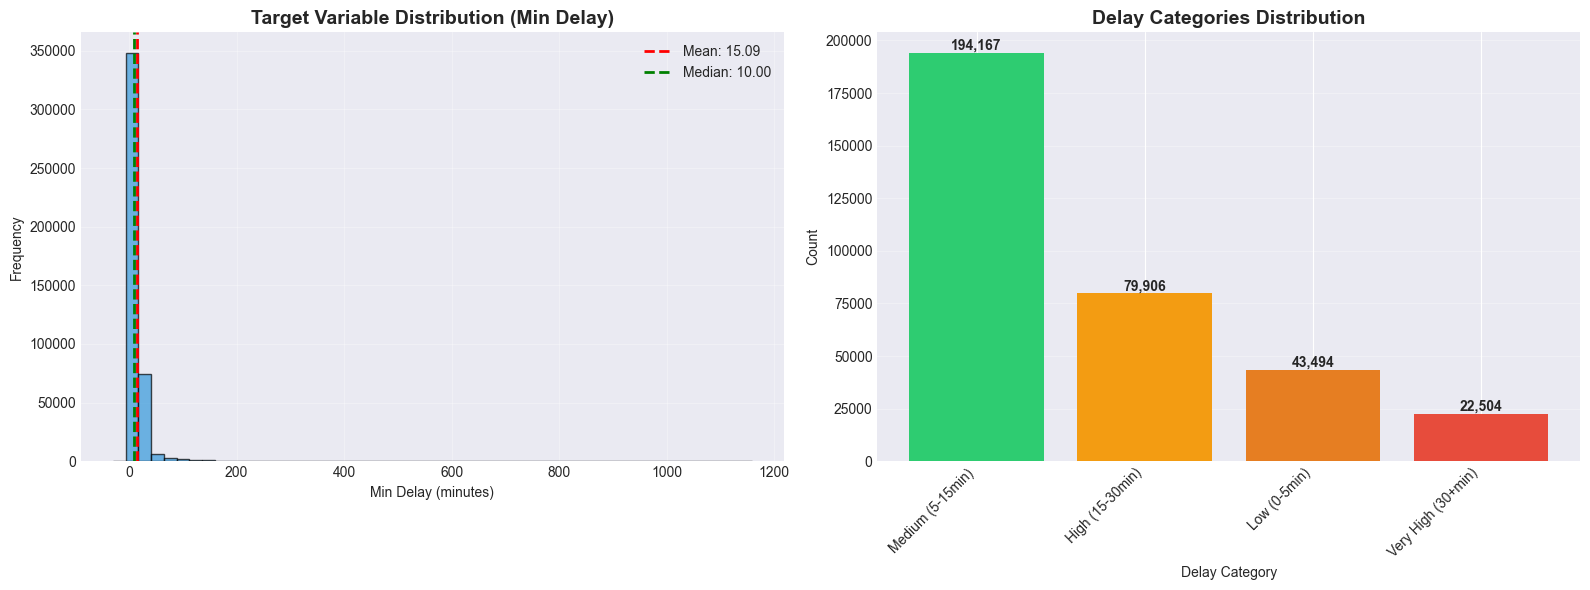


✓ Target variable defined: Min Delay
  Total records: 439,655
  Records with valid target: 439,655


In [45]:
# Define target variable
print("=" * 70)
print("TARGET VARIABLE DEFINITION")
print("=" * 70)

# Primary target: Min Delay (continuous - regression problem)
target_variable = 'Min Delay'

print(f"\nPrimary Target Variable: {target_variable}")
print(f"  Type: Continuous (Regression)")
print(f"  Description: Minutes of delay")

# Analyze target variable
print(f"\nTarget Variable Statistics:")
print(df[target_variable].describe())

# Optional: Create delay categories for classification (if needed)
df['Delay_Category'] = pd.cut(
    df[target_variable],
    bins=[0, 5, 15, 30, float('inf')],
    labels=['Low (0-5min)', 'Medium (5-15min)', 'High (15-30min)', 'Very High (30+min)']
)

print(f"\nDelay Categories (for potential classification):")
print(df['Delay_Category'].value_counts())
print(f"\nPercentage distribution:")
print(df['Delay_Category'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of Min Delay
axes[0].hist(df[target_variable].dropna(), bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0].set_title('Target Variable Distribution (Min Delay)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Min Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df[target_variable].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {df[target_variable].mean():.2f}')
axes[0].axvline(df[target_variable].median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {df[target_variable].median():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Delay categories
delay_cat_counts = df['Delay_Category'].value_counts()
axes[1].bar(range(len(delay_cat_counts)), delay_cat_counts.values, 
           color=['#2ecc71', '#f39c12', '#e67e22', '#e74c3c'])
axes[1].set_title('Delay Categories Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Delay Category')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(delay_cat_counts)))
axes[1].set_xticklabels([str(cat) for cat in delay_cat_counts.index], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(delay_cat_counts.values):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Target variable defined: {target_variable}")
print(f"  Total records: {len(df):,}")
print(f"  Records with valid target: {df[target_variable].notna().sum():,}")

## 6. Normalization and Transformation

Apply normalization and transformations to numerical features (e.g., log-transform for skewed targets, robust scaling for outlier-heavy variables).

In [46]:
# Assess normalization needs
print("=" * 70)
print("NORMALIZATION ASSESSMENT")
print("=" * 70)

numerical_features = ['Min Delay', 'Min Gap', 'Vehicle', 'Hour', 'Delay_Ratio']
normalization_assessment = []

for col in numerical_features:
    if col in df.columns:
        data = df[col].dropna()
        mean_val = data.mean()
        std_val = data.std()
        min_val = data.min()
        max_val = data.max()
        range_val = max_val - min_val
        cv = std_val / mean_val if mean_val != 0 else np.inf
        
        normalization_assessment.append({
            'Feature': col,
            'Mean': mean_val,
            'Std': std_val,
            'Min': min_val,
            'Max': max_val,
            'Range': range_val,
            'CV': cv,
            'Needs_Normalization': abs(cv) > 1 or range_val > 100
        })

norm_df = pd.DataFrame(normalization_assessment)
print("\nNormalization Assessment:")
print(norm_df.to_string(index=False))

NORMALIZATION ASSESSMENT

Normalization Assessment:
    Feature        Mean         Std   Min     Max   Range       CV  Needs_Normalization
  Min Delay   15.086468   42.167547 -30.0  1158.0  1188.0 2.795058                 True
    Min Gap   23.893896   44.792944   0.0  1158.0  1158.0 1.874661                 True
    Vehicle 4948.046725 3564.249277   0.0 98035.0 98035.0 0.720335                 True
       Hour   11.592703    5.549635   0.0    23.0    23.0 0.478718                False
Delay_Ratio    0.538392    3.110316  -5.0   585.0   590.0 5.777044                 True



APPLYING NORMALIZATION AND TRANSFORMATIONS
✓ Min Delay: Applied log transformation (Min_Delay_Log)
✓ Min Gap: Applied RobustScaler (Min_Gap_Scaled)
✓ Vehicle: Applied StandardScaler (Vehicle_Scaled)
✓ Delay_Ratio: Applied RobustScaler (Delay_Ratio_Scaled)


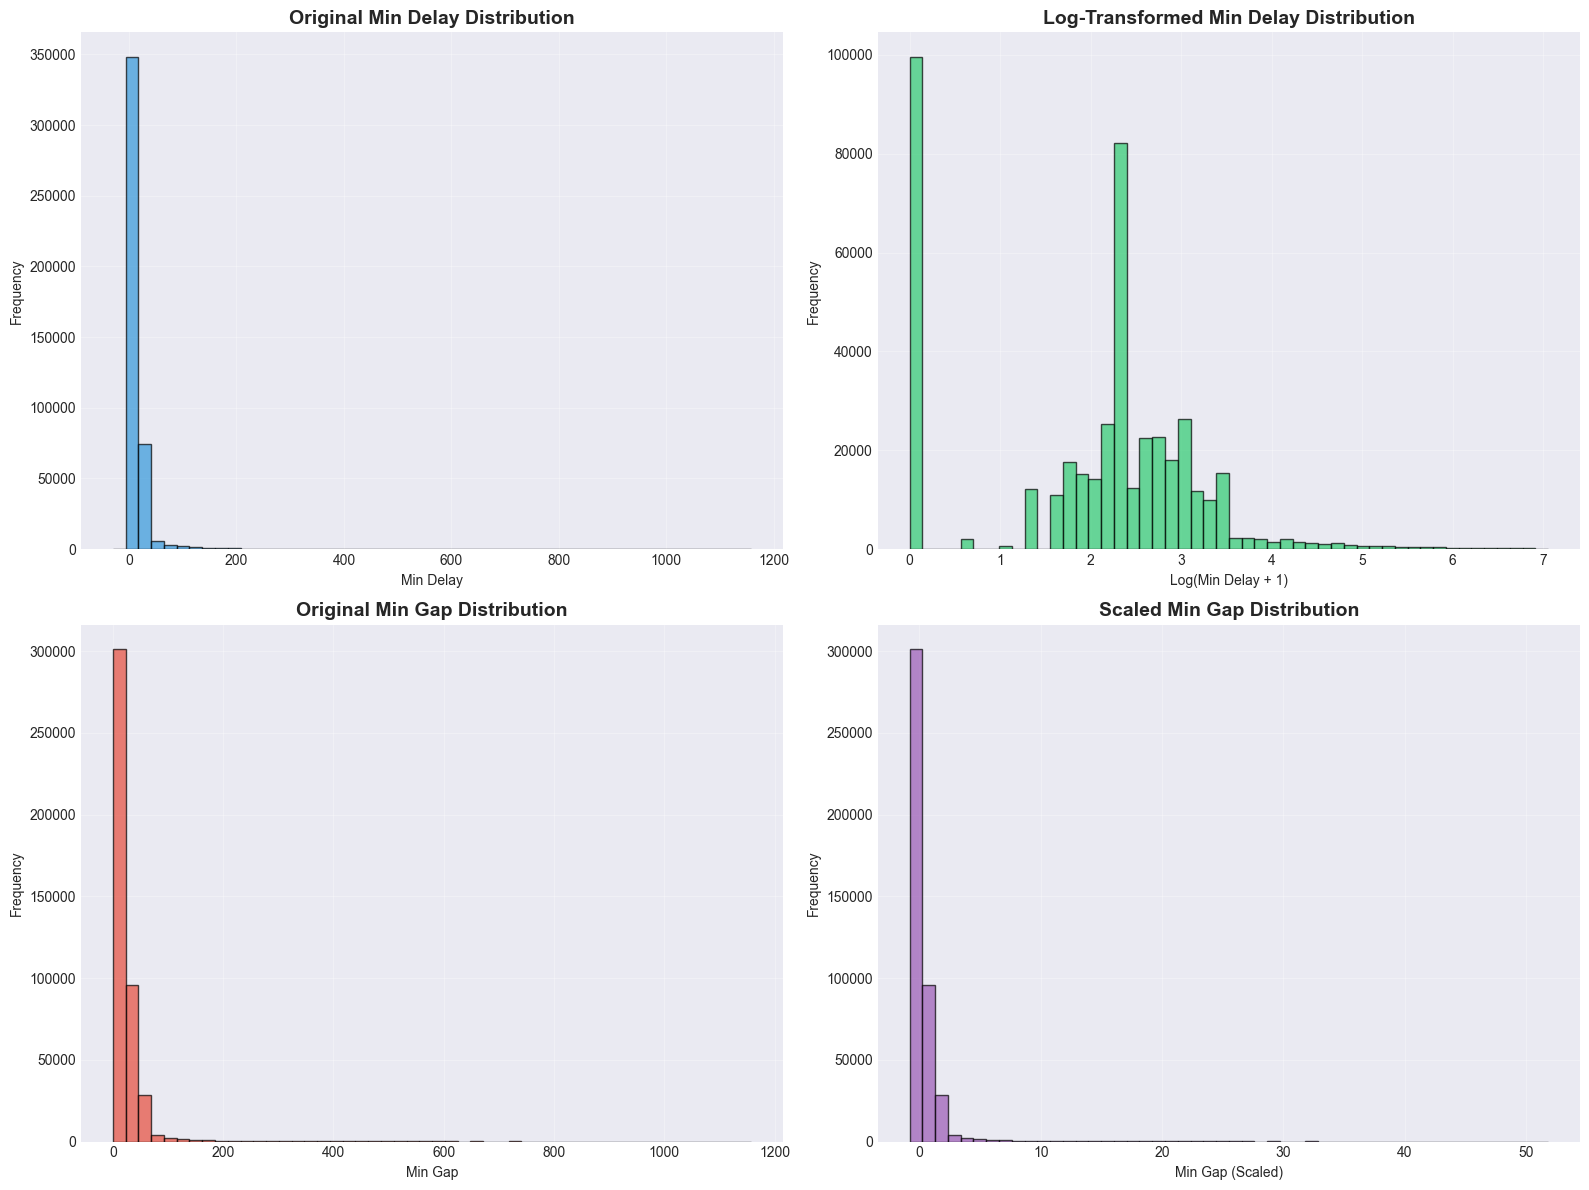


✓ Normalization and transformations applied!
  Note: Original columns preserved for reference


In [47]:
# Apply normalization/transformation
print("\n" + "=" * 70)
print("APPLYING NORMALIZATION AND TRANSFORMATIONS")
print("=" * 70)

from sklearn.preprocessing import StandardScaler, RobustScaler

# Store original values for reference
df['Min_Delay_Original'] = df['Min Delay'].copy()
df['Min_Gap_Original'] = df['Min Gap'].copy()

# 1. Log transformation for Min Delay (right-skewed)
df['Min_Delay_Log'] = np.log1p(df['Min Delay'])  # log(1+x) to handle zeros
print("✓ Min Delay: Applied log transformation (Min_Delay_Log)")

# 2. Standardization for Min Gap (using RobustScaler - less sensitive to outliers)
scaler_min_gap = RobustScaler()
df['Min_Gap_Scaled'] = scaler_min_gap.fit_transform(df[['Min Gap']])
print("✓ Min Gap: Applied RobustScaler (Min_Gap_Scaled)")

# 3. Standardization for Vehicle (if needed)
if 'Vehicle' in df.columns:
    scaler_vehicle = StandardScaler()
    df['Vehicle_Scaled'] = scaler_vehicle.fit_transform(df[['Vehicle']])
    print("✓ Vehicle: Applied StandardScaler (Vehicle_Scaled)")

# 4. Standardization for Delay_Ratio
if 'Delay_Ratio' in df.columns:
    scaler_ratio = RobustScaler()
    df['Delay_Ratio_Scaled'] = scaler_ratio.fit_transform(df[['Delay_Ratio']])
    print("✓ Delay_Ratio: Applied RobustScaler (Delay_Ratio_Scaled)")

# Visualize transformations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Original Min Delay
axes[0, 0].hist(df['Min_Delay_Original'].dropna(), bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Original Min Delay Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Min Delay')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# Log-transformed Min Delay
axes[0, 1].hist(df['Min_Delay_Log'].dropna(), bins=50, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Log-Transformed Min Delay Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Log(Min Delay + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Original Min Gap
axes[1, 0].hist(df['Min_Gap_Original'].dropna(), bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Original Min Gap Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Min Gap')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(alpha=0.3)

# Scaled Min Gap
axes[1, 1].hist(df['Min_Gap_Scaled'].dropna(), bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Scaled Min Gap Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Min Gap (Scaled)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Normalization and transformations applied!")
print("  Note: Original columns preserved for reference")

## 7. Data Imbalance Analysis

Analyze imbalance across **years** and **vehicle types** (this will inform later sampling / validation strategies).

In [48]:
# Analyze data imbalance
print("=" * 70)
print("DATA IMBALANCE ANALYSIS")
print("=" * 70)

# Records by year and vehicle type
imbalance_matrix = pd.crosstab(df['Year'], df['Vehicle_Type'], margins=True)
print("\nRecords by Year and Vehicle Type:")
print(imbalance_matrix)

# Calculate imbalance ratios
print("\nImbalance Ratios (relative to total):")
imbalance_pct = pd.crosstab(df['Year'], df['Vehicle_Type'], normalize='index') * 100
print(imbalance_pct.round(2))

# Yearly distribution
yearly_counts = df.groupby('Year').size()
print(f"\nYearly Distribution:")
print(yearly_counts)
print(f"\nMax/Min ratio: {yearly_counts.max() / yearly_counts.min():.2f}x")
print(f"  Most records: {yearly_counts.idxmax()} ({yearly_counts.max():,})")
print(f"  Least records: {yearly_counts.idxmin()} ({yearly_counts.min():,})")

DATA IMBALANCE ANALYSIS

Records by Year and Vehicle Type:
Vehicle_Type     BUS  STREETCAR  SUBWAY     All
Year                                           
2017            5300       1300    7590   14190
2018            6969       1622    1873   10464
2019            6743       1595    1871   10209
2020            4282        802    1339    6423
2021            2832       1018    1216    5066
2022           58707      17655   19895   96257
2023           56207      14413   22949   93569
2024           59643      14206   26467  100316
2025           63029      14419   25713  103161
All           263712      67030  108913  439655

Imbalance Ratios (relative to total):
Vehicle_Type    BUS  STREETCAR  SUBWAY
Year                                  
2017          37.35       9.16   53.49
2018          66.60      15.50   17.90
2019          66.05      15.62   18.33
2020          66.67      12.49   20.85
2021          55.90      20.09   24.00
2022          60.99      18.34   20.67
2023          

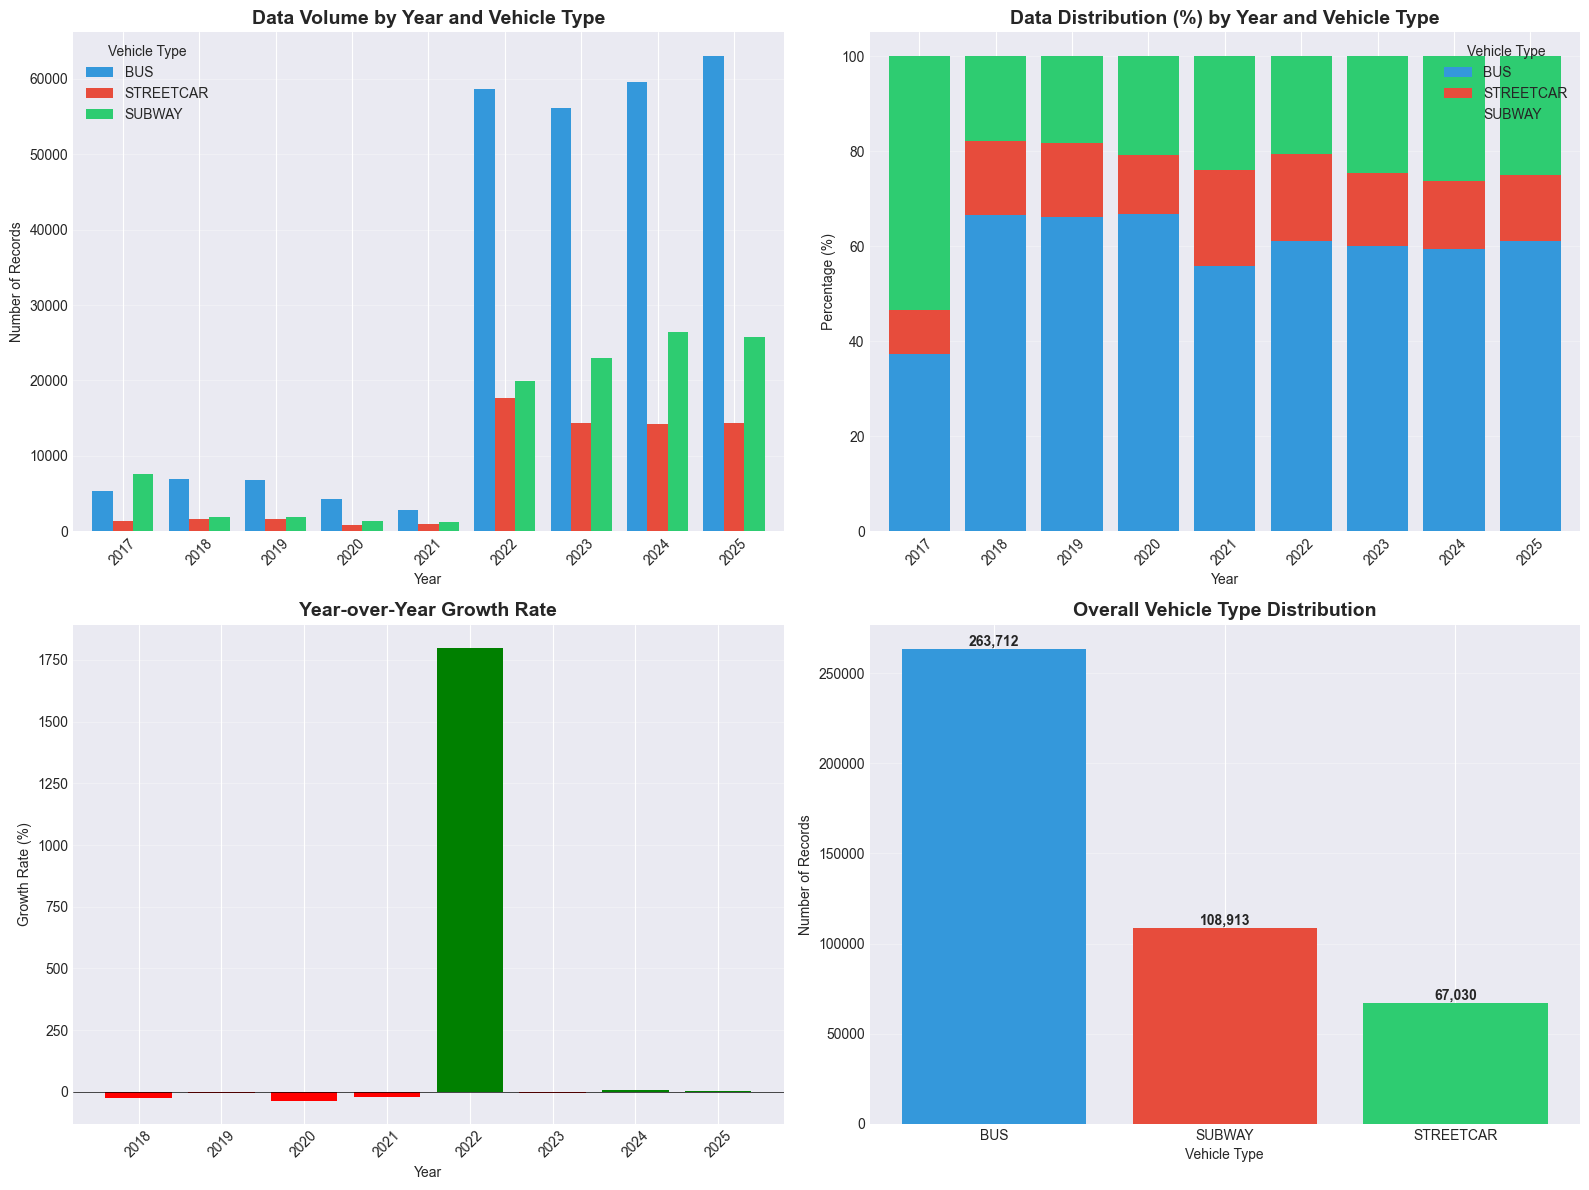


DATA IMBALANCE HANDLING STRATEGY

Recommendations:
  1. Use stratified sampling when splitting data
  2. Consider class weights in models
  3. Use time-based split (earlier years for training, later for testing)
  4. Consider resampling techniques if needed
  5. Monitor model performance across different vehicle types and years


In [49]:
# Visualize data imbalance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Records count by year and vehicle type
imbalance_counts = pd.crosstab(df['Year'], df['Vehicle_Type'])
imbalance_counts.plot(kind='bar', ax=axes[0, 0], color=['#3498db', '#e74c3c', '#2ecc71'], width=0.8)
axes[0, 0].set_title('Data Volume by Year and Vehicle Type', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].legend(title='Vehicle Type')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Percentage by year and vehicle type
imbalance_counts_pct = pd.crosstab(df['Year'], df['Vehicle_Type'], normalize='index') * 100
imbalance_counts_pct.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                          color=['#3498db', '#e74c3c', '#2ecc71'], width=0.8)
axes[0, 1].set_title('Data Distribution (%) by Year and Vehicle Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Vehicle Type')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Yearly growth rate
growth_rate = yearly_counts.pct_change() * 100
axes[1, 0].bar(growth_rate.index.astype(str), growth_rate.values, 
               color=['green' if x > 0 else 'red' for x in growth_rate.values])
axes[1, 0].set_title('Year-over-Year Growth Rate', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Growth Rate (%)')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Vehicle type distribution
vehicle_counts = df['Vehicle_Type'].value_counts()
axes[1, 1].bar(vehicle_counts.index, vehicle_counts.values, 
              color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 1].set_title('Overall Vehicle Type Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Vehicle Type')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(vehicle_counts.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Handling strategy for data imbalance
print("\n" + "=" * 70)
print("DATA IMBALANCE HANDLING STRATEGY")
print("=" * 70)
print("\nRecommendations:")
print("  1. Use stratified sampling when splitting data")
print("  2. Consider class weights in models")
print("  3. Use time-based split (earlier years for training, later for testing)")
print("  4. Consider resampling techniques if needed")
print("  5. Monitor model performance across different vehicle types and years")

## 8. Processed Dataset Summary

Quick check that the dataset is consistent, has the expected columns/features, and is ready to be saved for future modeling notebooks.

In [50]:
# Final dataset summary
print("=" * 70)
print("PROCESSED DATASET SUMMARY")
print("=" * 70)

print(f"\nDataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nDate Range: {df['Date'].min().date()} to {df['Date'].max().date()}")

print(f"\nVehicle Type Distribution:")
print(df['Vehicle_Type'].value_counts())
print(f"\nPercentage:")
print((df['Vehicle_Type'].value_counts() / len(df) * 100).round(2))

print(f"\nYear Distribution:")
year_counts = df['Year'].value_counts().sort_index()
print(year_counts)

print(f"\nMissing Values (after processing):")
remaining_missing = df.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
if len(remaining_missing) > 0:
    print(remaining_missing)
else:
    print("  ✅ No missing values remaining!")

print(f"\nTarget Variable: {target_variable}")
print(f"  Mean: {df[target_variable].mean():.2f} minutes")
print(f"  Median: {df[target_variable].median():.2f} minutes")
print(f"  Std: {df[target_variable].std():.2f} minutes")
print(f"  Min: {df[target_variable].min():.2f} minutes")
print(f"  Max: {df[target_variable].max():.2f} minutes")

print(f"\nKey Features Created:")
feature_list = [
    'Year', 'Month', 'DayOfWeek', 'Hour',
    'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos',
    'IsWeekend', 'IsRushHour', 'IsPeakHour', 'IsNight',
    'Season', 'Delay_Ratio',
    'Min_Delay_Log', 'Min_Gap_Scaled', 'Delay_Ratio_Scaled',
    'Delay_Category'
]
print(f"  Temporal: {[f for f in feature_list if f in df.columns]}")
print(f"  Cyclical: {[f for f in df.columns if '_sin' in f or '_cos' in f]}")
print(f"  Binary flags: {[f for f in df.columns if f.startswith('Is')]}")
print(f"  Transformed: {[f for f in df.columns if 'Scaled' in f or 'Log' in f]}")

print(f"\n✓ Dataset ready for modeling!")
print(f"  Total features: {len(df.columns)}")
print(f"  Target variable: {target_variable}")
print(f"  Records: {len(df):,}")

PROCESSED DATASET SUMMARY

Dataset Shape: 439,655 rows × 39 columns

Date Range: 2017-01-01 to 2025-12-31

Vehicle Type Distribution:
Vehicle_Type
BUS          263712
SUBWAY       108913
STREETCAR     67030
Name: count, dtype: int64

Percentage:
Vehicle_Type
BUS          59.98
SUBWAY       24.77
STREETCAR    15.25
Name: count, dtype: float64

Year Distribution:
Year
2017     14190
2018     10464
2019     10209
2020      6423
2021      5066
2022     96257
2023     93569
2024    100316
2025    103161
Name: count, dtype: int64

Missing Values (after processing):
Hour              411042
Minute            411042
Hour_sin          411042
Hour_cos          411042
Delay_Category     99584
Min_Delay_Log          2
dtype: int64

Target Variable: Min Delay
  Mean: 15.09 minutes
  Median: 10.00 minutes
  Std: 42.17 minutes
  Min: -30.00 minutes
  Max: 1158.00 minutes

Key Features Created:
  Temporal: ['Year', 'Month', 'DayOfWeek', 'Hour', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',

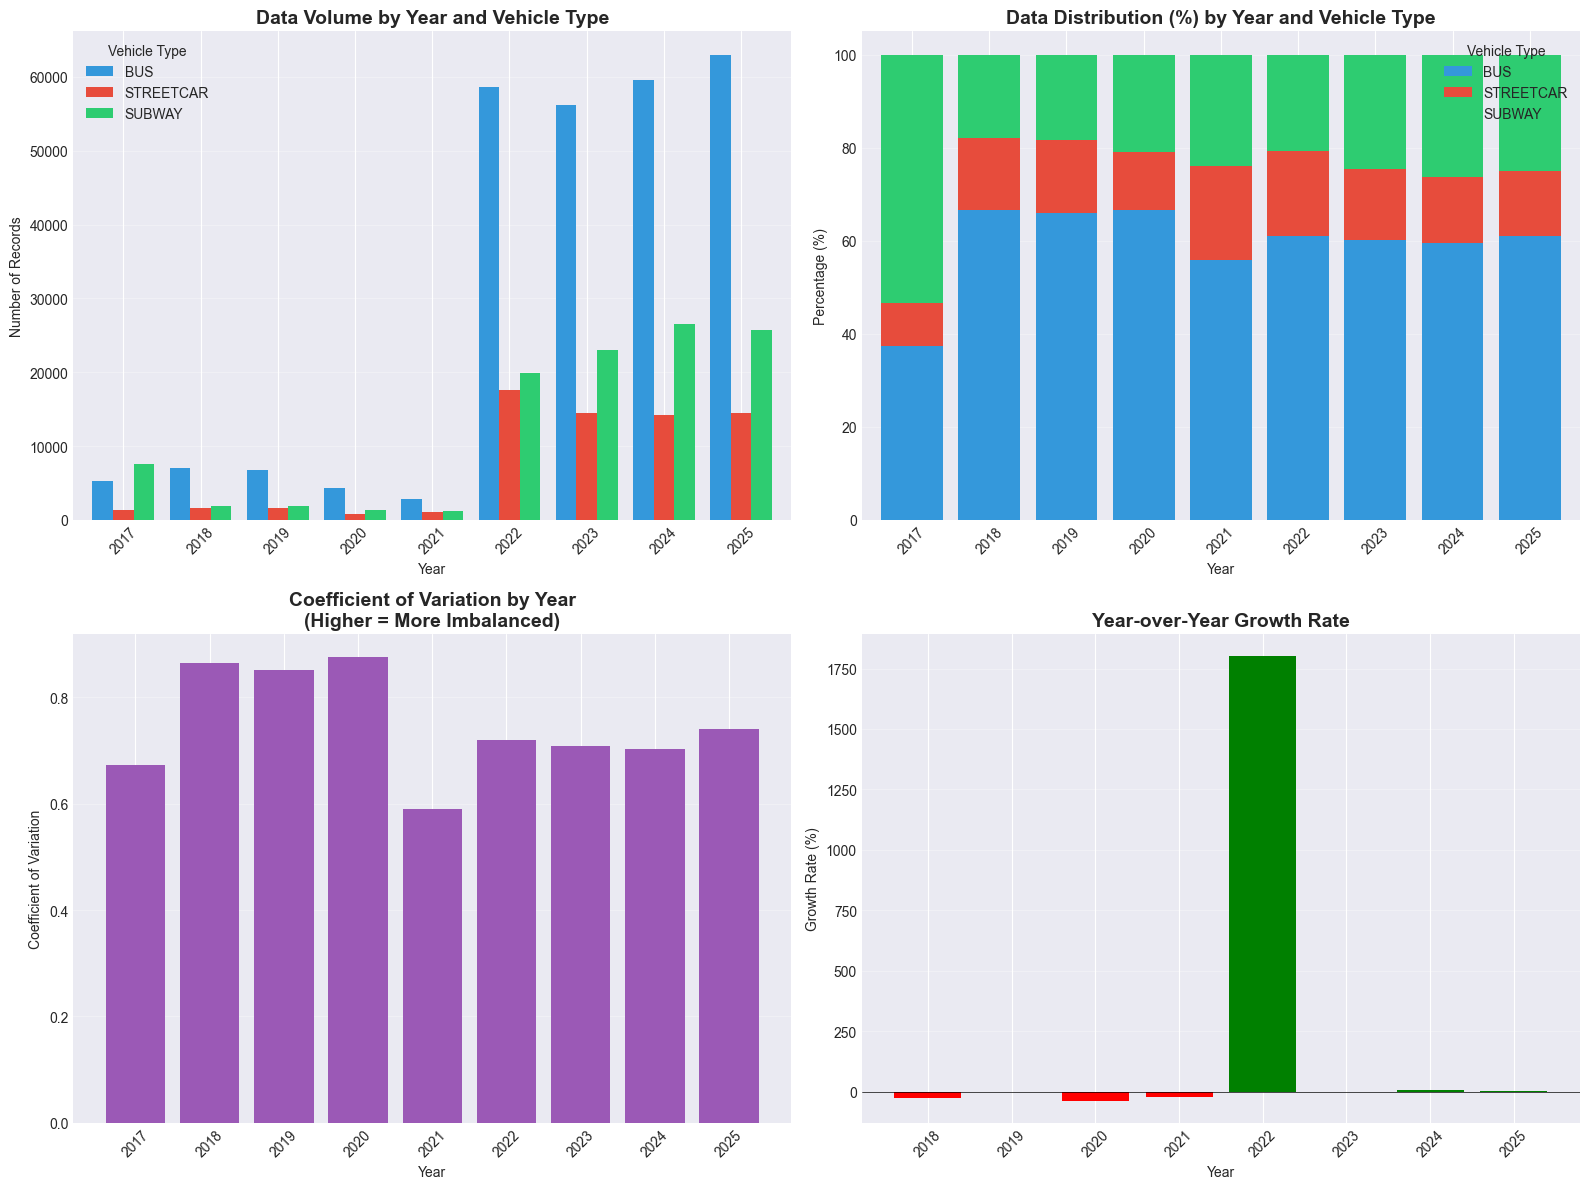


Key Observations:
  - Total records: 439,655
  - Year range: 2017 to 2025
  - Most records in year: 2025 (103,161 records)
  - Least records in year: 2021 (5,066 records)
  - Ratio (max/min): 20.36x


In [51]:
# Visualize data imbalance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Records count by year and vehicle type
imbalance_counts = pd.crosstab(df['Year'], df['Vehicle_Type'])
imbalance_counts.plot(kind='bar', ax=axes[0, 0], color=['#3498db', '#e74c3c', '#2ecc71'], width=0.8)
axes[0, 0].set_title('Data Volume by Year and Vehicle Type', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].legend(title='Vehicle Type')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Percentage by year and vehicle type
imbalance_counts_pct = pd.crosstab(df['Year'], df['Vehicle_Type'], normalize='index') * 100
imbalance_counts_pct.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                          color=['#3498db', '#e74c3c', '#2ecc71'], width=0.8)
axes[0, 1].set_title('Data Distribution (%) by Year and Vehicle Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].legend(title='Vehicle Type')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Coefficient of variation by year (measure of imbalance)
cv_by_year = df.groupby('Year')['Vehicle_Type'].apply(lambda x: x.value_counts().std() / x.value_counts().mean())
axes[1, 0].bar(cv_by_year.index.astype(str), cv_by_year.values, color='#9b59b6')
axes[1, 0].set_title('Coefficient of Variation by Year\n(Higher = More Imbalanced)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Coefficient of Variation')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Yearly growth rate
yearly_counts = df.groupby('Year').size()
growth_rate = yearly_counts.pct_change() * 100
axes[1, 1].bar(growth_rate.index.astype(str), growth_rate.values, 
               color=['green' if x > 0 else 'red' for x in growth_rate.values])
axes[1, 1].set_title('Year-over-Year Growth Rate', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Growth Rate (%)')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"  - Total records: {len(df):,}")
print(f"  - Year range: {df['Year'].min()} to {df['Year'].max()}")
print(f"  - Most records in year: {yearly_counts.idxmax()} ({yearly_counts.max():,} records)")
print(f"  - Least records in year: {yearly_counts.idxmin()} ({yearly_counts.min():,} records)")
print(f"  - Ratio (max/min): {yearly_counts.max() / yearly_counts.min():.2f}x")

## 9. Save Processed Dataset

Save a processed, unified dataset that can be used later for training (we are **not** training yet in this notebook).

In [52]:
# Save processed dataset for future modeling (no training here)
print("=" * 70)
print("SAVING PROCESSED DATASET")
print("=" * 70)

OUTPUT_DIR = BASE_DIR / "aiProject" / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

processed_file = OUTPUT_DIR / "ttc_delays_processed_2017_2025.csv"

# Pick a reasonable set of columns (raw + engineered + transformed + target)
columns_to_save = [
    # identifiers / raw
    'Vehicle_Type', 'Date', 'Time', 'Day', 'Line', 'Station', 'Code', 'Bound', 'Vehicle',
    # target + core numeric
    'Min Delay', 'Min Gap',
    # engineered temporal
    'Year', 'Month', 'DayOfWeek', 'DayName', 'DayOfMonth', 'WeekOfYear', 'Hour', 'Minute',
    # cyclical encodings
    'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos',
    # flags
    'IsWeekend', 'IsRushHour', 'IsPeakHour', 'IsNight',
    # engineered
    'Season', 'Delay_Ratio',
    # transformed
    'Min_Delay_Log', 'Min_Gap_Scaled', 'Vehicle_Scaled', 'Delay_Ratio_Scaled',
    # optional
    'Vehicle_Type_Encoded', 'Delay_Category',
]

columns_to_save = [c for c in columns_to_save if c in df.columns]
df_processed_final = df[columns_to_save].copy()

# Save
_df_rows, _df_cols = df_processed_final.shape
df_processed_final.to_csv(processed_file, index=False)

size_mb = processed_file.stat().st_size / (1024 * 1024)
print(f"✓ Saved: {processed_file}")
print(f"  Shape: {_df_rows:,} rows × {_df_cols} columns")
print(f"  Size:  {size_mb:.2f} MB")

SAVING PROCESSED DATASET
✓ Saved: /Users/feliperosa/Downloads/02_codigos/github/centennialCollege_AICapstoneProject/aiProject/outputs/ttc_delays_processed_2017_2025.csv
  Shape: 439,655 rows × 37 columns
  Size:  125.66 MB


## 10. Exploratory Analysis (Processed Data)

Light EDA on the processed dataset to validate transformations and highlight key patterns.

CORRELATION ANALYSIS - PROCESSED FEATURES


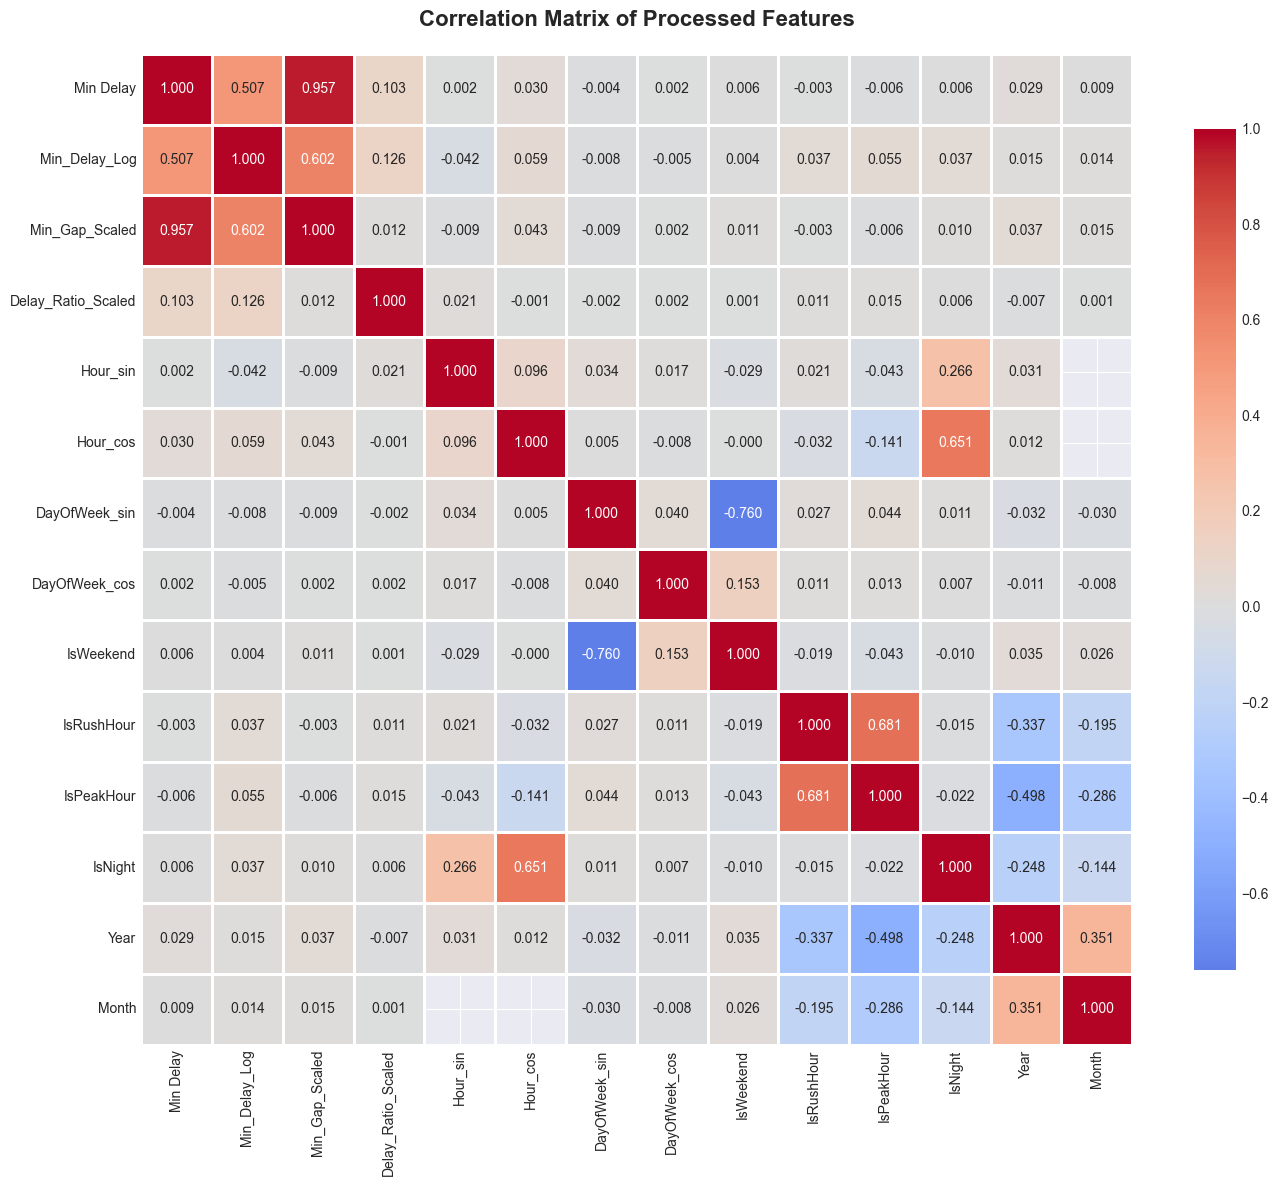


Correlations with Min Delay (target):
Min Delay             1.000000
Min_Gap_Scaled        0.956696
Min_Delay_Log         0.507145
Delay_Ratio_Scaled    0.103233
Hour_cos              0.030440
Year                  0.029268
Month                 0.008762
IsNight               0.006359
IsWeekend             0.005656
DayOfWeek_cos         0.001581
Hour_sin              0.001513
IsRushHour           -0.003473
DayOfWeek_sin        -0.004079
IsPeakHour           -0.006282
Name: Min Delay, dtype: float64


In [53]:
# Correlation analysis of processed features
print("=" * 70)
print("CORRELATION ANALYSIS - PROCESSED FEATURES")
print("=" * 70)

# Select numerical features for correlation
corr_features = ['Min Delay', 'Min_Delay_Log', 'Min_Gap_Scaled', 'Delay_Ratio_Scaled',
                'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
                'IsWeekend', 'IsRushHour', 'IsPeakHour', 'IsNight', 'Year', 'Month']
corr_features = [f for f in corr_features if f in df.columns]

correlation_matrix = df[corr_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Processed Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlations with target
print("\nCorrelations with Min Delay (target):")
delay_corr = correlation_matrix['Min Delay'].sort_values(ascending=False)
print(delay_corr)

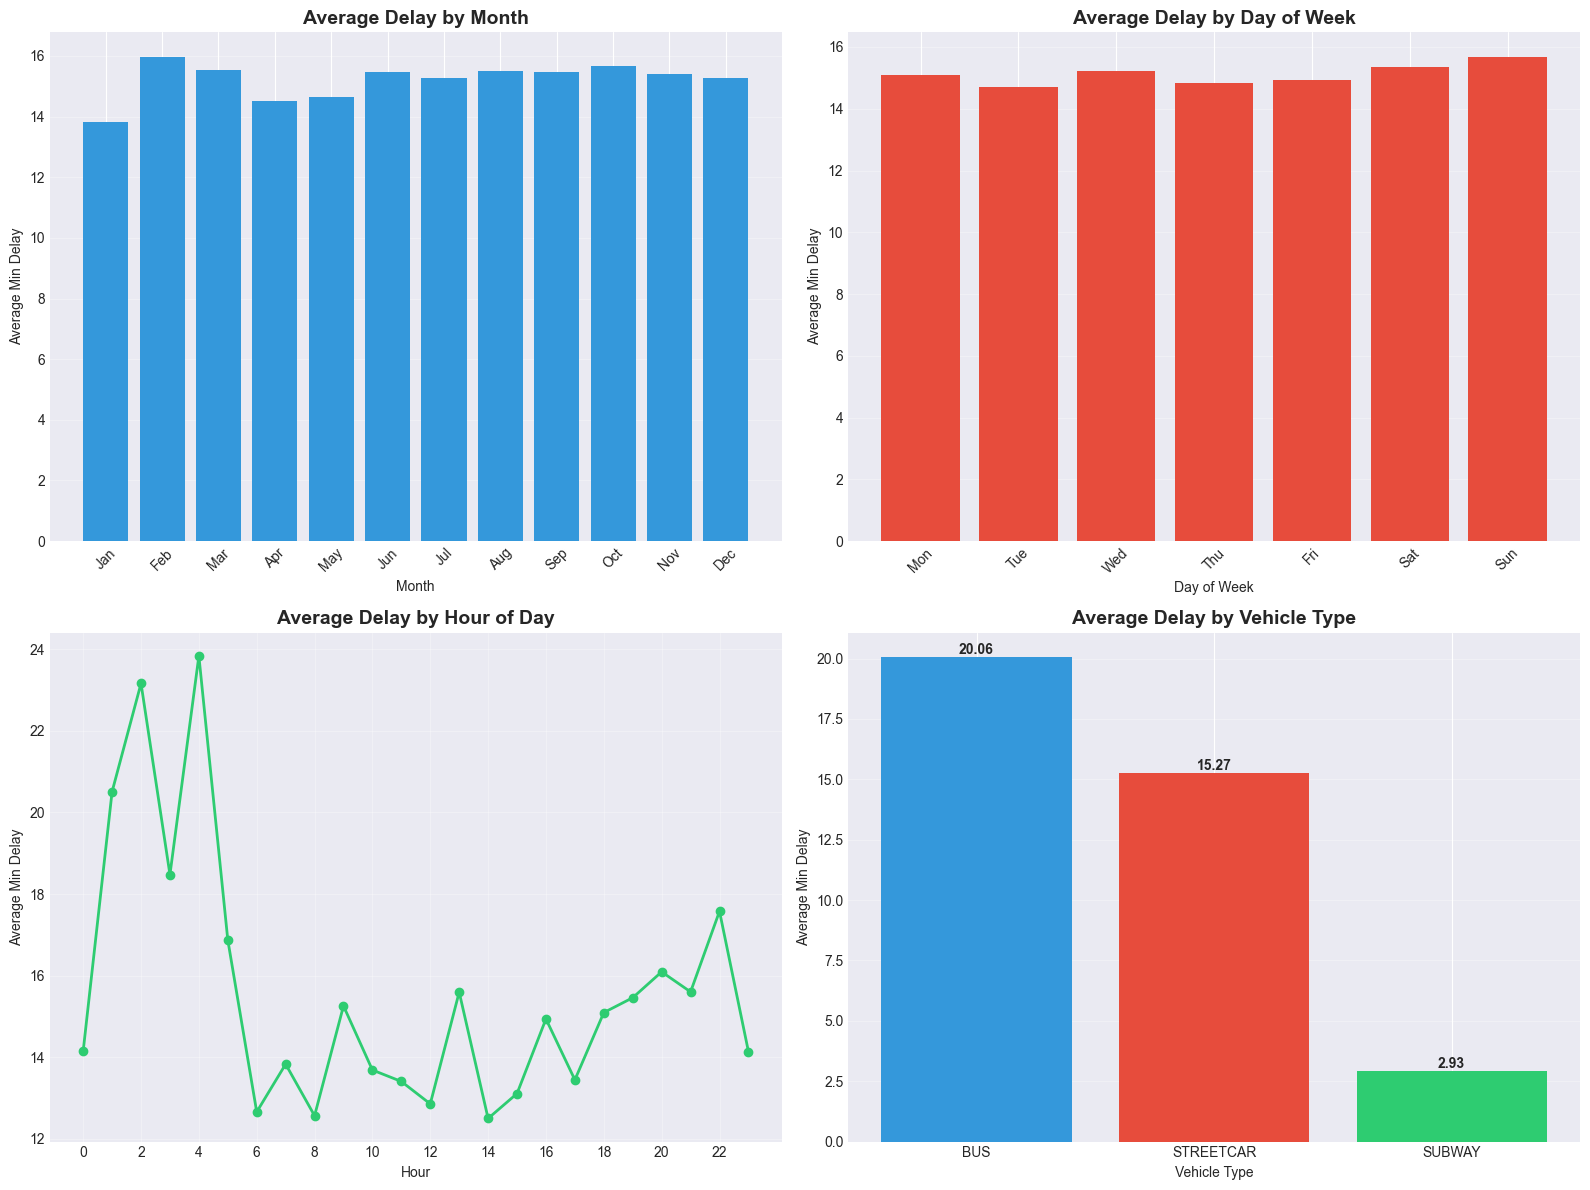

In [54]:
# Temporal patterns in processed data
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Average delay by month
monthly_avg = df.groupby('Month')['Min Delay'].mean()
axes[0, 0].bar(range(1, 13), monthly_avg.values, color='#3498db')
axes[0, 0].set_title('Average Delay by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Average Min Delay')
axes[0, 0].set_xticks(range(1, 13))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].set_xticklabels(month_names, rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Average delay by day of week
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = df.groupby('DayName')['Min Delay'].mean().reindex(dow_order)
axes[0, 1].bar(range(len(dow_order)), dow_avg.values, color='#e74c3c')
axes[0, 1].set_title('Average Delay by Day of Week', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Average Min Delay')
axes[0, 1].set_xticks(range(len(dow_order)))
axes[0, 1].set_xticklabels([d[:3] for d in dow_order], rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Average delay by hour
hourly_avg = df.groupby('Hour')['Min Delay'].mean()
axes[1, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6, color='#2ecc71')
axes[1, 0].set_title('Average Delay by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Average Min Delay')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].grid(alpha=0.3)

# 4. Delay by vehicle type
delay_by_type = df.groupby('Vehicle_Type')['Min Delay'].mean()
axes[1, 1].bar(delay_by_type.index, delay_by_type.values, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1, 1].set_title('Average Delay by Vehicle Type', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Vehicle Type')
axes[1, 1].set_ylabel('Average Min Delay')
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(delay_by_type.values):
    axes[1, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [55]:
# Assess normalization needs
print("=" * 70)
print("NORMALIZATION NEEDS ASSESSMENT")
print("=" * 70)

numerical_features = ['Min Delay', 'Min Gap', 'Vehicle', 'Hour']
normalization_assessment = pd.DataFrame()

for col in numerical_features:
    if col in df.columns:
        data = df[col].dropna()
        mean_val = data.mean()
        std_val = data.std()
        min_val = data.min()
        max_val = data.max()
        range_val = max_val - min_val
        cv = std_val / mean_val if mean_val != 0 else np.inf  # Coefficient of variation
        
        normalization_assessment = pd.concat([normalization_assessment, pd.DataFrame({
            'Feature': [col],
            'Mean': [mean_val],
            'Std': [std_val],
            'Min': [min_val],
            'Max': [max_val],
            'Range': [range_val],
            'CV': [cv],
            'Needs_Normalization': [abs(cv) > 1 or range_val > 100]
        })], ignore_index=True)

print("\nNormalization Assessment:")
print(normalization_assessment.to_string(index=False))

NORMALIZATION NEEDS ASSESSMENT

Normalization Assessment:
  Feature        Mean         Std   Min     Max   Range       CV  Needs_Normalization
Min Delay   15.086468   42.167547 -30.0  1158.0  1188.0 2.795058                 True
  Min Gap   23.893896   44.792944   0.0  1158.0  1158.0 1.874661                 True
  Vehicle 4948.046725 3564.249277   0.0 98035.0 98035.0 0.720335                 True
     Hour   11.592703    5.549635   0.0    23.0    23.0 0.478718                False


## Appendix A — Correlation Analysis (optional)

CORRELATION ANALYSIS

Correlation Matrix:
           Min Delay  Min Gap   Year  Month  DayOfWeek   Hour  Vehicle
Min Delay      1.000    0.957  0.029  0.009      0.004 -0.006    0.037
Min Gap        0.957    1.000  0.037  0.015      0.009  0.003    0.074
Year           0.029    0.037  1.000  0.351      0.036 -0.021    0.035
Month          0.009    0.015  0.351  1.000      0.027    NaN    0.024
DayOfWeek      0.004    0.009  0.036  0.027      1.000  0.027   -0.004
Hour          -0.006    0.003 -0.021    NaN      0.027  1.000   -0.032
Vehicle        0.037    0.074  0.035  0.024     -0.004 -0.032    1.000


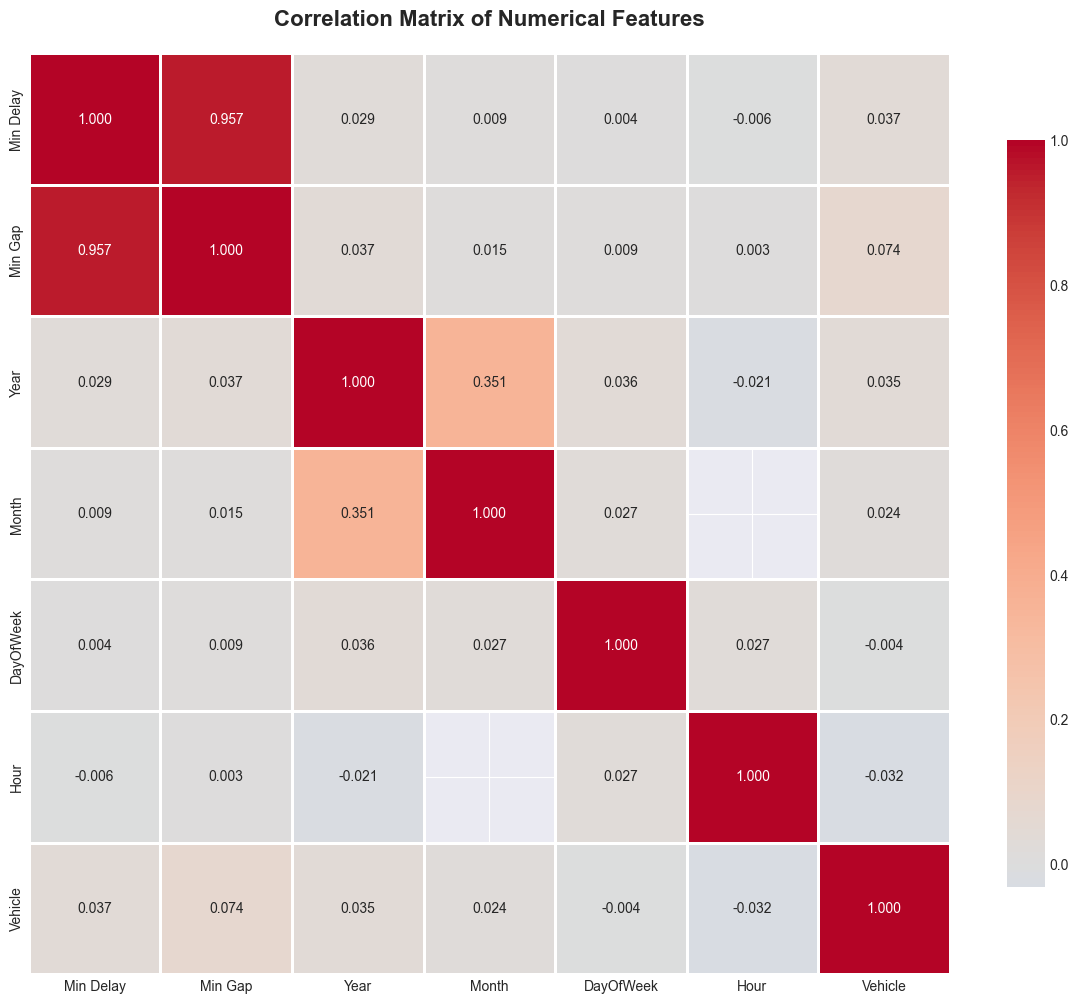


Correlations with Min Delay (target variable):
Min Delay    1.000000
Min Gap      0.956696
Vehicle      0.036625
Year         0.029268
Month        0.008762
DayOfWeek    0.004236
Hour        -0.006444
Name: Min Delay, dtype: float64


In [56]:
# Correlation analysis
print("=" * 70)
print("CORRELATION ANALYSIS")
print("=" * 70)

# Select numerical columns for correlation
corr_cols = ['Min Delay', 'Min Gap', 'Year', 'Month', 'DayOfWeek', 'Hour', 'Vehicle']
corr_cols = [col for col in corr_cols if col in df.columns]

correlation_matrix = df[corr_cols].corr()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Strong correlations with target (Min Delay)
print("\nCorrelations with Min Delay (target variable):")
delay_corr = correlation_matrix['Min Delay'].sort_values(ascending=False)
print(delay_corr)